[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/activation/early_stopping.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Early stopping

This notebook shows how to use early stopping to avoid overfitting in a neural network. We will use the [Fashion-MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset and a multilayer perceptron (MLP) model.

<img src="img/fashion-mnist.png" width="600px"/>

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
repo='data-science-course'
module='deep-learning/activation'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git 2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/. 2>/dev/null
    !mv {repo}/{module}/data/* data/. 2>/dev/null

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

Note: you may need to restart the kernel to use updated packages.



## Data preparation

We download, split, and scale the Fashion-MNIST dataset. 

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# break the training set into training and validation sets
N_VAL_INSTANCES = 10_000
X_train, y_train = X_train_full[:-N_VAL_INSTANCES], y_train_full[:-N_VAL_INSTANCES]
X_val, y_val = X_train_full[-N_VAL_INSTANCES:], y_train_full[-N_VAL_INSTANCES:]
# show dataset info
print(f"Shape of X_train = {X_train.shape} and y_train = {y_train.shape}.")
print(f"Shape of X_val = {X_val.shape} and y_val = {y_val.shape}.")
print(f"Shape of X_test = {X_test.shape} and y_test = {y_test.shape}.")
CLASS_LABELS = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# We rescale the colors to real numbers between 0 and 1
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

Shape of X_train = (50000, 28, 28) and y_train = (50000,).
Shape of X_val = (10000, 28, 28) and y_val = (10000,).
Shape of X_test = (10000, 28, 28) and y_test = (10000,).


## Multilayer Perceptron (MLP) model

We create a MLP network with two hidden layers of 300 and 100 neurons (ReLU activation function) and an output layer of 10 neurons (softmax activation function). 

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training with a fixed number of epochs

We first train the model with 20 epochs and batch size of 32.


Epoch 1/20


1563/1563 [==============================] - 9s 5ms/step - loss: 0.4925 - accuracy: 0.8243 - val_loss: 0.4016 - val_accuracy: 0.8476
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3673 - accuracy: 0.8650 - val_loss: 0.3635 - val_accuracy: 0.8670
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3317 - accuracy: 0.8784 - val_loss: 0.3700 - val_accuracy: 0.8645
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3079 - accuracy: 0.8869 - val_loss: 0.3429 - val_accuracy: 0.8735
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2887 - accuracy: 0.8928 - val_loss: 0.3229 - val_accuracy: 0.8845
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2714 - accuracy: 0.8996 - val_loss: 0.3085 - val_accuracy: 0.8862
Epoch 7/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2603 - accuracy: 0.9017 - val_loss: 0.3122 - val_accura

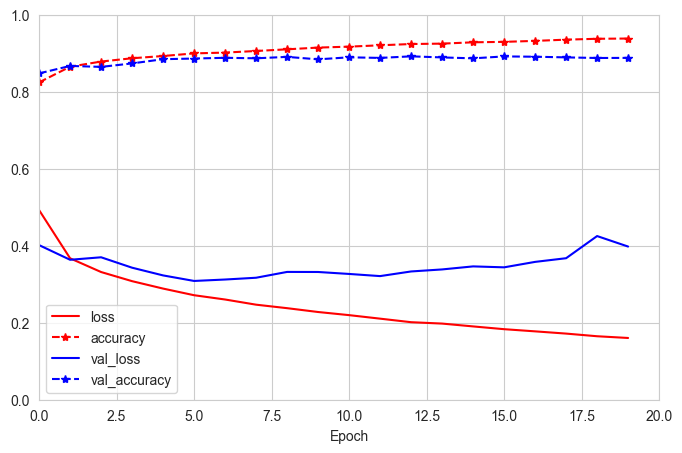

In [4]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
EPOCHS = 20
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, y_val))
# Let's take a look at how test and train loss and accuracy evolved during training
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, EPOCHS], ylim=[0, 1], grid=True, xlabel="Epoch",
    # red/blue, dashed(--), continuous (-), shape(. or *)
    style=["r-", "r--*", "b-", "b--*"])  # train-loss=red(-), train-accuracy=red(--*), val_loss=blue(-), val_accuracy=blue(--*)
plt.show()

## Early stopping

We now train the model with early stopping. To that aim, we create a callback function that stops when, after `patience` epochs, the val loss is not improving. That is why it is called early stop. We use the `EarlyStopping` callback from Keras.

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1557 - accuracy: 0.9418 - val_loss: 0.3949 - val_accuracy: 0.8914
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1476 - accuracy: 0.9432 - val_loss: 0.3937 - val_accuracy: 0.8934
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1446 - accuracy: 0.9445 - val_loss: 0.4062 - val_accuracy: 0.8947
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1408 - accuracy: 0.9472 - val_loss: 0.4176 - val_accuracy: 0.8940


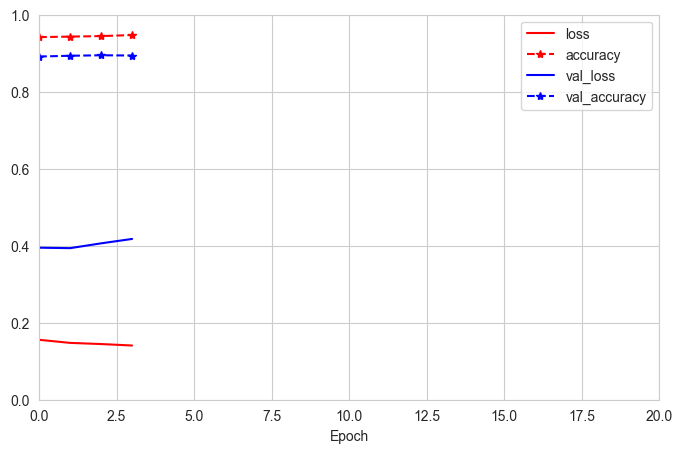

In [6]:
# Recompile the model to forget the learned weights
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# We create a callback for early stopping (patience=2)
# restore_best_weights = True makes the model to choose the one with the best weights (forget the last ones)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# fit the model, passing the callback
history_early_stop = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, y_val),
                               callbacks=[early_stopping_callback])

# Let's take a look at how test and train loss and accuracy evolved during training
pd.DataFrame(history_early_stop.history).plot(
    figsize=(8, 5), xlim=[0, EPOCHS], ylim=[0, 1], grid=True, xlabel="Epoch",
    # red/blue, dashed(--), continuous (-), shape(. or *)
    style=["r-", "r--*", "b-", "b--*"])  # train-loss=red(-), train-accuracy=red(--*), val_loss=blue(-), val_accuracy=blue(--*)
plt.show()

## ✨ Questions ✨ 

1. What is the difference between the two previous training processes?
2. Identify the two main benefits of early stopping?

### Answers

*Write your answers here.*

